In [1]:
import numpy as np
import librosa
import os
from os import walk
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import datetime 
import pandas as pd

**Affichage des chromagramme et des moyennes de la PCP**


In [2]:
def get_chroma_vector(wav_file_path, target_duration=3):
    y, sr = librosa.load(wav_file_path, sr=None)
    current_duration = librosa.get_duration(y=y, sr=sr)
    
    # Calculez le facteur d'étirement ou de compression nécessaire
    time_stretch_factor = current_duration / target_duration
    # Étirez ou compressez le signal audio pour atteindre la durée cible
    y_stretched = librosa.effects.time_stretch(y,rate=time_stretch_factor)
    # Calculez le chromagramme à partir du signal modifié
    chroma = np.array(librosa.feature.chroma_stft(y=y_stretched, sr=sr))
    df_chroma = pd.DataFrame(chroma)
    moyenne_par_colonne = df_chroma.mean()
    # Sélectionnez les colonnes dont la moyenne est inférieure ou égale à 0.6
    colonnes_a_conserver = moyenne_par_colonne[moyenne_par_colonne <= 0.65].index

    # Créez un nouveau DataFrame en ne conservant que les colonnes sélectionnées
    df_filtered = df_chroma[colonnes_a_conserver]
    new_chroma = df_filtered.to_numpy()
    return new_chroma


In [3]:
violin_file = r'C:/Users/mgere/VS_Code_Workspace/ESEO/PFE_Analayse_musicale/Chords_generation/chords_wav/198Leg_Gmaj.wav'
flute_file = r'C:\Users\mgere\VS_Code_Workspace\ESEO\PFE_Analayse_musicale\Chords_generation\chords_wav\Flores_Gmaj.wav'
piano_file = r'C:\Users\mgere\VS_Code_Workspace\ESEO\PFE_Analayse_musicale\Chords_generation\chords_wav\Piano0_Gmaj.wav'
guitar_file = r'C:\Users\mgere\VS_Code_Workspace\ESEO\PFE_Analayse_musicale\Chords_generation\chords_wav\Guitar_Gmaj.wav'

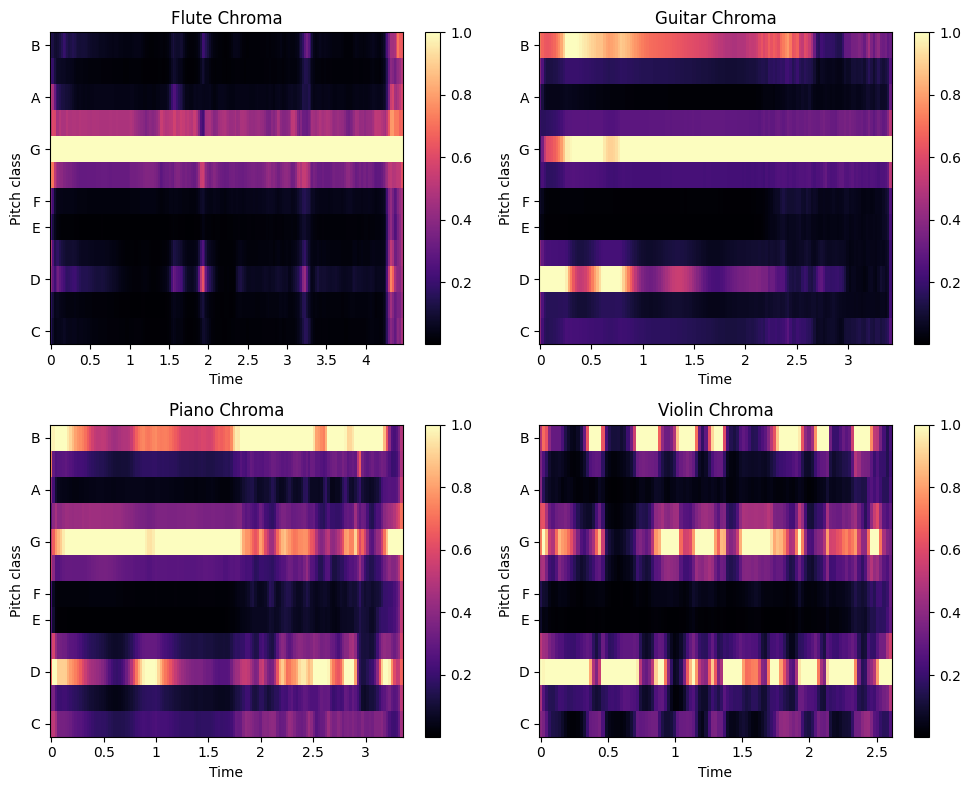

In [4]:
# Obtenez les 4 chromagrammes (remplacez ces lignes par les données réelles que vous avez)
chroma1 = get_chroma_vector(flute_file)
chroma2 = get_chroma_vector(guitar_file)
chroma3 = get_chroma_vector(piano_file)
chroma4 = get_chroma_vector(violin_file)

# Créez une figure avec une grille de 2x2 sous-plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Affichez chaque chromagramme dans un sous-plot
img1 = librosa.display.specshow(chroma1, y_axis='chroma', x_axis='time', ax=axes[0, 0])
axes[0, 0].set_title('Flute Chroma')

img2 = librosa.display.specshow(chroma2, y_axis='chroma', x_axis='time', ax=axes[0, 1])
axes[0, 1].set_title('Guitar Chroma')

img3 = librosa.display.specshow(chroma3, y_axis='chroma', x_axis='time', ax=axes[1, 0])
axes[1, 0].set_title('Piano Chroma')

img4 = librosa.display.specshow(chroma4, y_axis='chroma', x_axis='time', ax=axes[1, 1])
axes[1, 1].set_title('Violin Chroma')

# Ajoutez une barre de couleur pour chaque sous-plot
fig.colorbar(img1, ax=axes[0, 0])
fig.colorbar(img2, ax=axes[0, 1])
fig.colorbar(img3, ax=axes[1, 0])
fig.colorbar(img4, ax=axes[1, 1])

# Ajustez l'espacement entre les sous-plots
plt.tight_layout()

# Affichez la figure
plt.show()


In [5]:
def get_feature(file_path):
 # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)

  feature = chroma_mean
  return feature

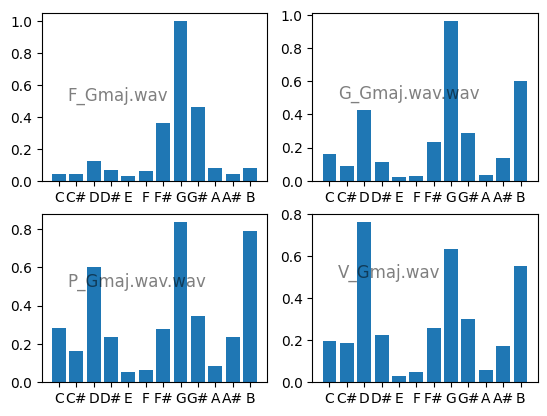

In [6]:
names = ['C', 'C#', 'D','D#','E','F','F#','G','G#','A','A#','B'] # nom des barres

values_f = get_feature(flute_file).tolist()
values_g = get_feature(guitar_file).tolist()
values_p = get_feature(piano_file).tolist()
values_v = get_feature(violin_file).tolist()

plt.subplot(221)
plt.bar(names, values_f)
plt.text(0.5, 0.5, "F_Gmaj.wav", size=12, alpha=.5)

plt.subplot(222)
plt.bar(names, values_g)
plt.text(0.5,0.5, "G_Gmaj.wav.wav", size=12, alpha=.5)

plt.subplot(223)
plt.bar(names, values_p)
plt.text(0.5,0.5, "P_Gmaj.wav.wav", size=12, alpha=.5)

plt.subplot(224)
plt.bar(names, values_v)
plt.text(0.5,0.5, "V_Gmaj.wav", size=12, alpha=.5)

plt.show()


**Creation du Dataset**

Récupération des données et labélisation

In [7]:
def extract_features(directory):
    features = []
    labels = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            feature = get_feature(file_path)
            label = file.split('_')[1].split('.')[0]
            features.append(feature)
            labels.append(label)

    return features, labels

In [8]:
dir = r'C:/Users/mgere/VS_Code_Workspace/ESEO/PFE_Analayse_musicale/Chords_generation/chords_wav'
features, labels = extract_features(dir)

Mélange aléatoire des données et encodage des labels

In [9]:
permutations = np.random.permutation(len(features))

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

features = np.array(features)[permutations]
labels_encoded = np.array(labels_encoded)[permutations]

**Phase d'apprentissage : SVM**

In [10]:
# Importations
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [11]:
# Séparation des données : entrainement / test
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

SVM Linéaire :

** **

In [12]:
# Entraînement du modèle SVM linéaire
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = svm_model.predict(X_test_scaled)

In [13]:
print("Number of unique classes in y_test:", len(np.unique(y_test)))
print("Number of unique classes in y_pred:", len(np.unique(y_pred)))

print("Number of classes in label_encoder:", len(label_encoder.classes_))

Number of unique classes in y_test: 65
Number of unique classes in y_pred: 59
Number of classes in label_encoder: 68


In [14]:
# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.36637931034482757


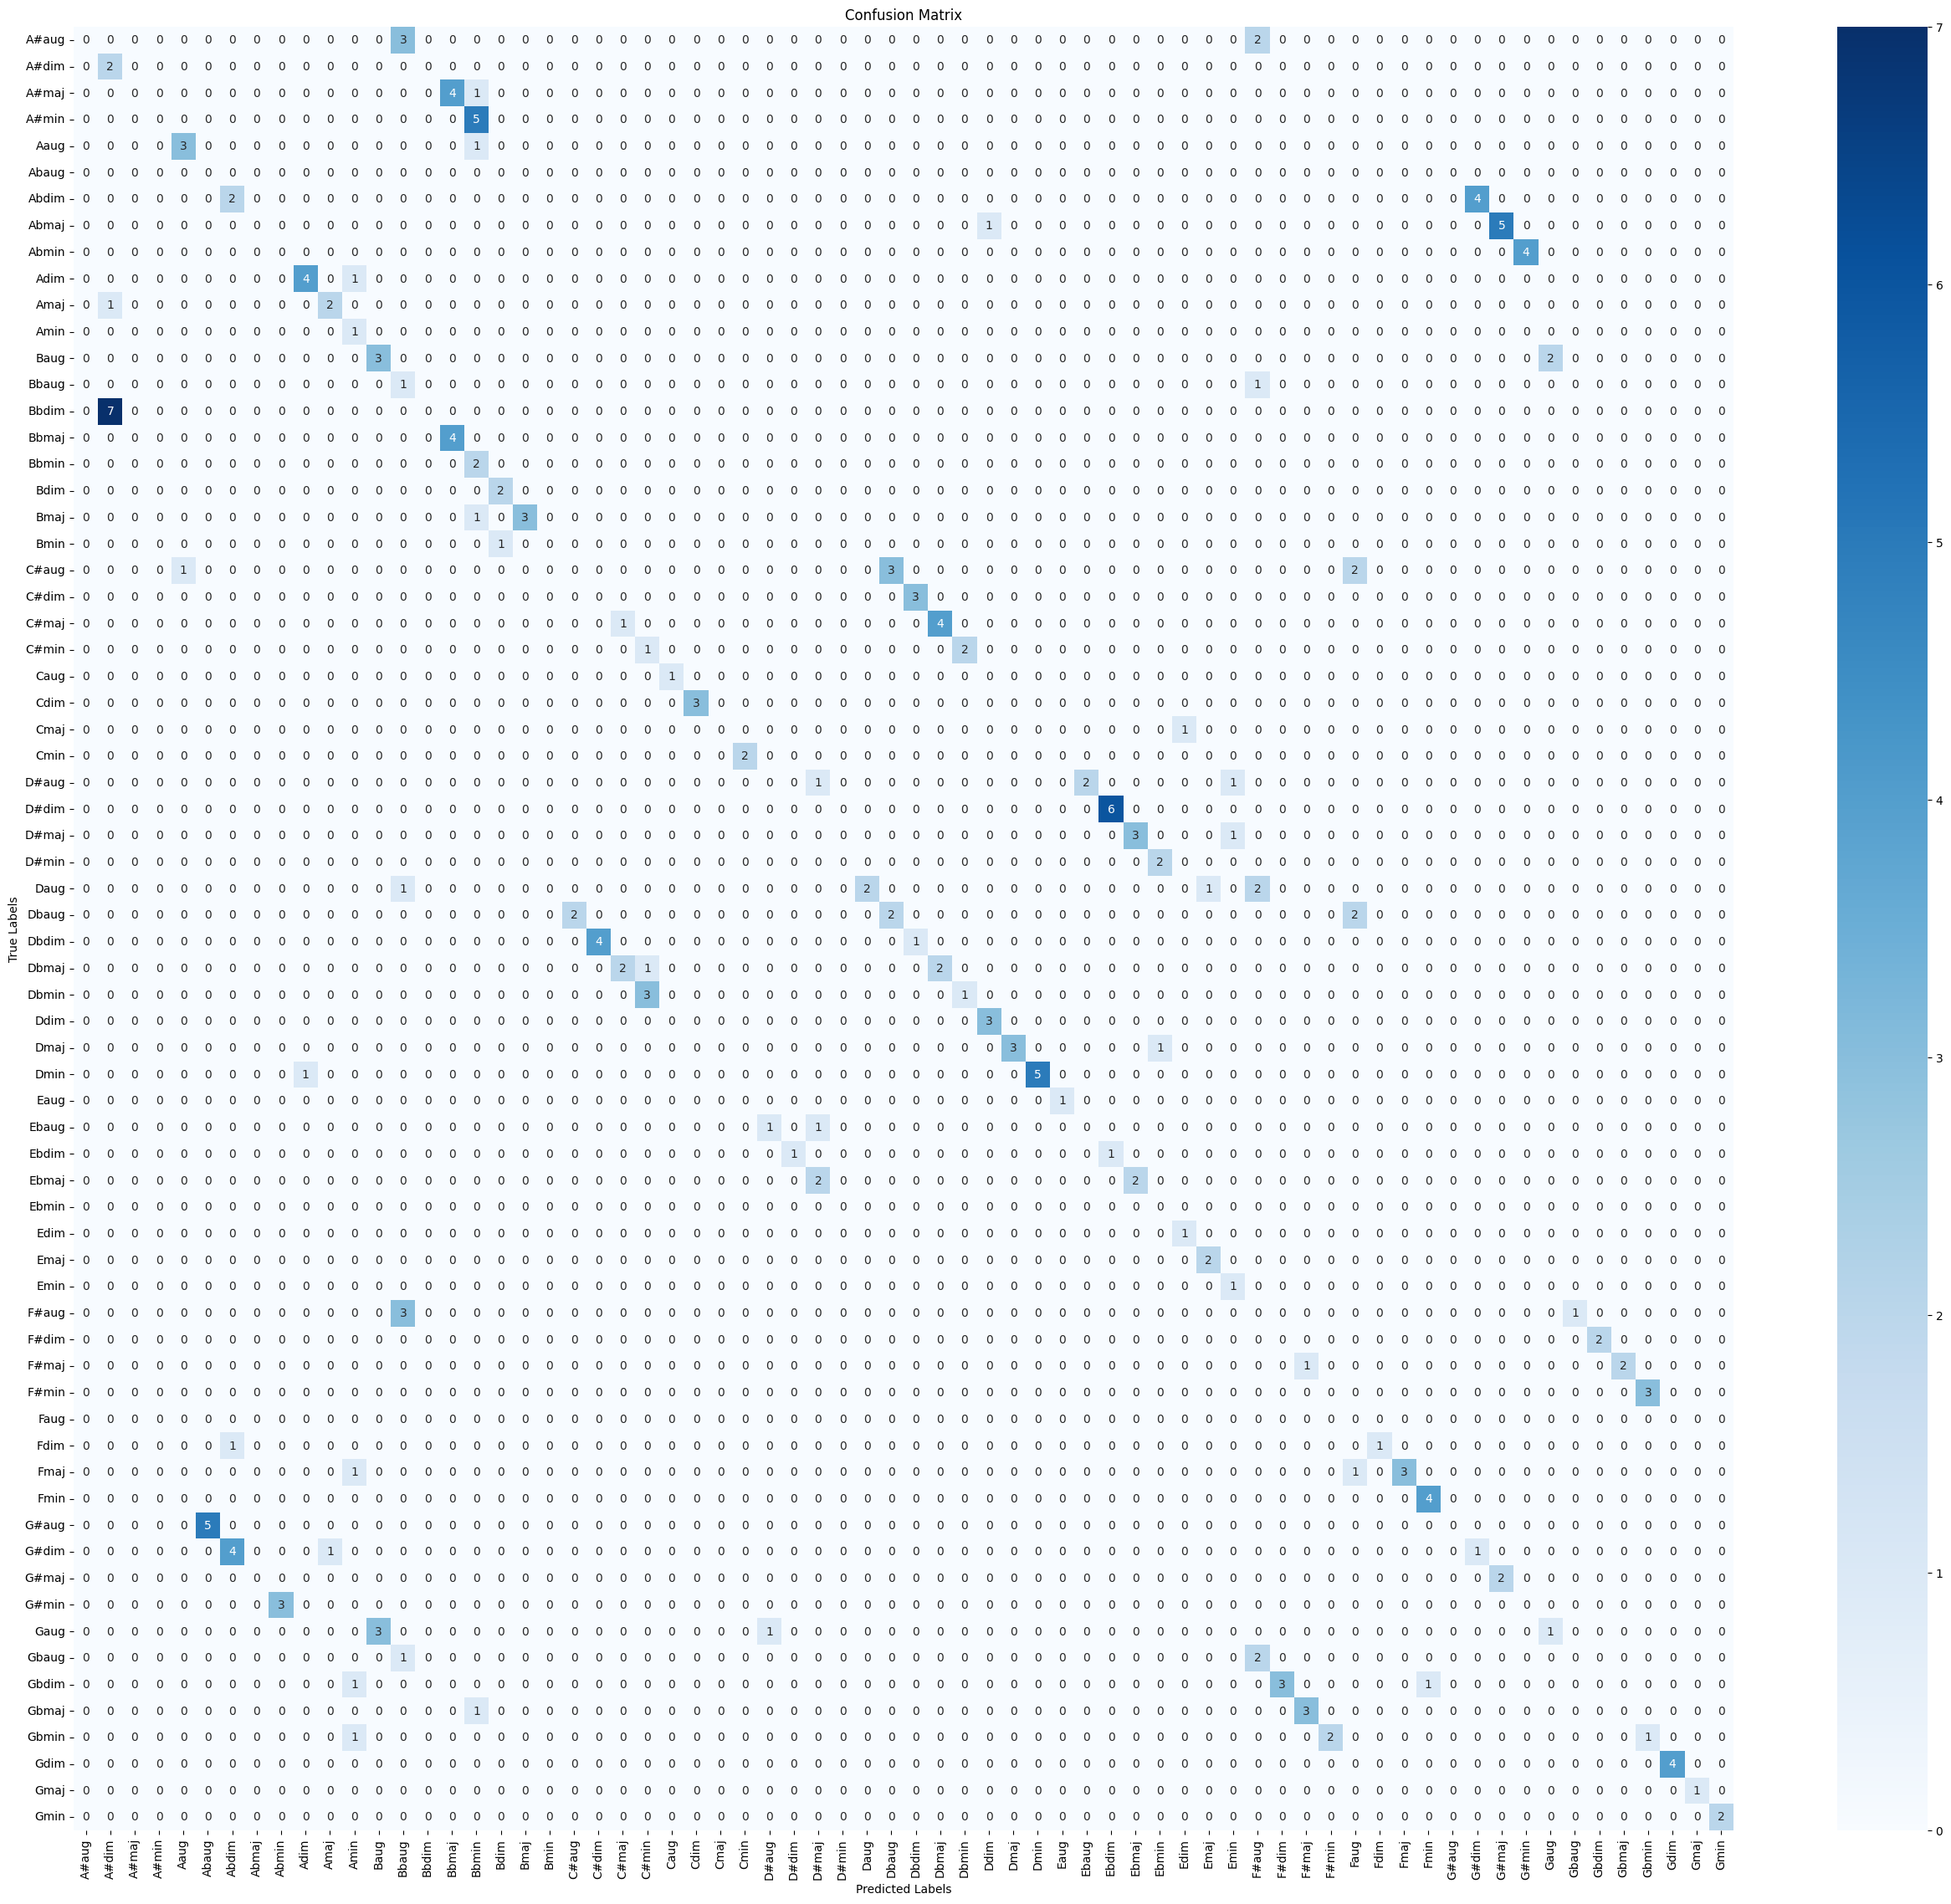

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(32, 28))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

SVM avec noyau RBF (Radial Basis Function) :

** **

In [16]:
# Entraînement du modèle SVM linéaire
svm_model = SVC(kernel='rbf', C=1.0)
svm_model.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = svm_model.predict(X_test_scaled)

In [17]:
# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.3448275862068966


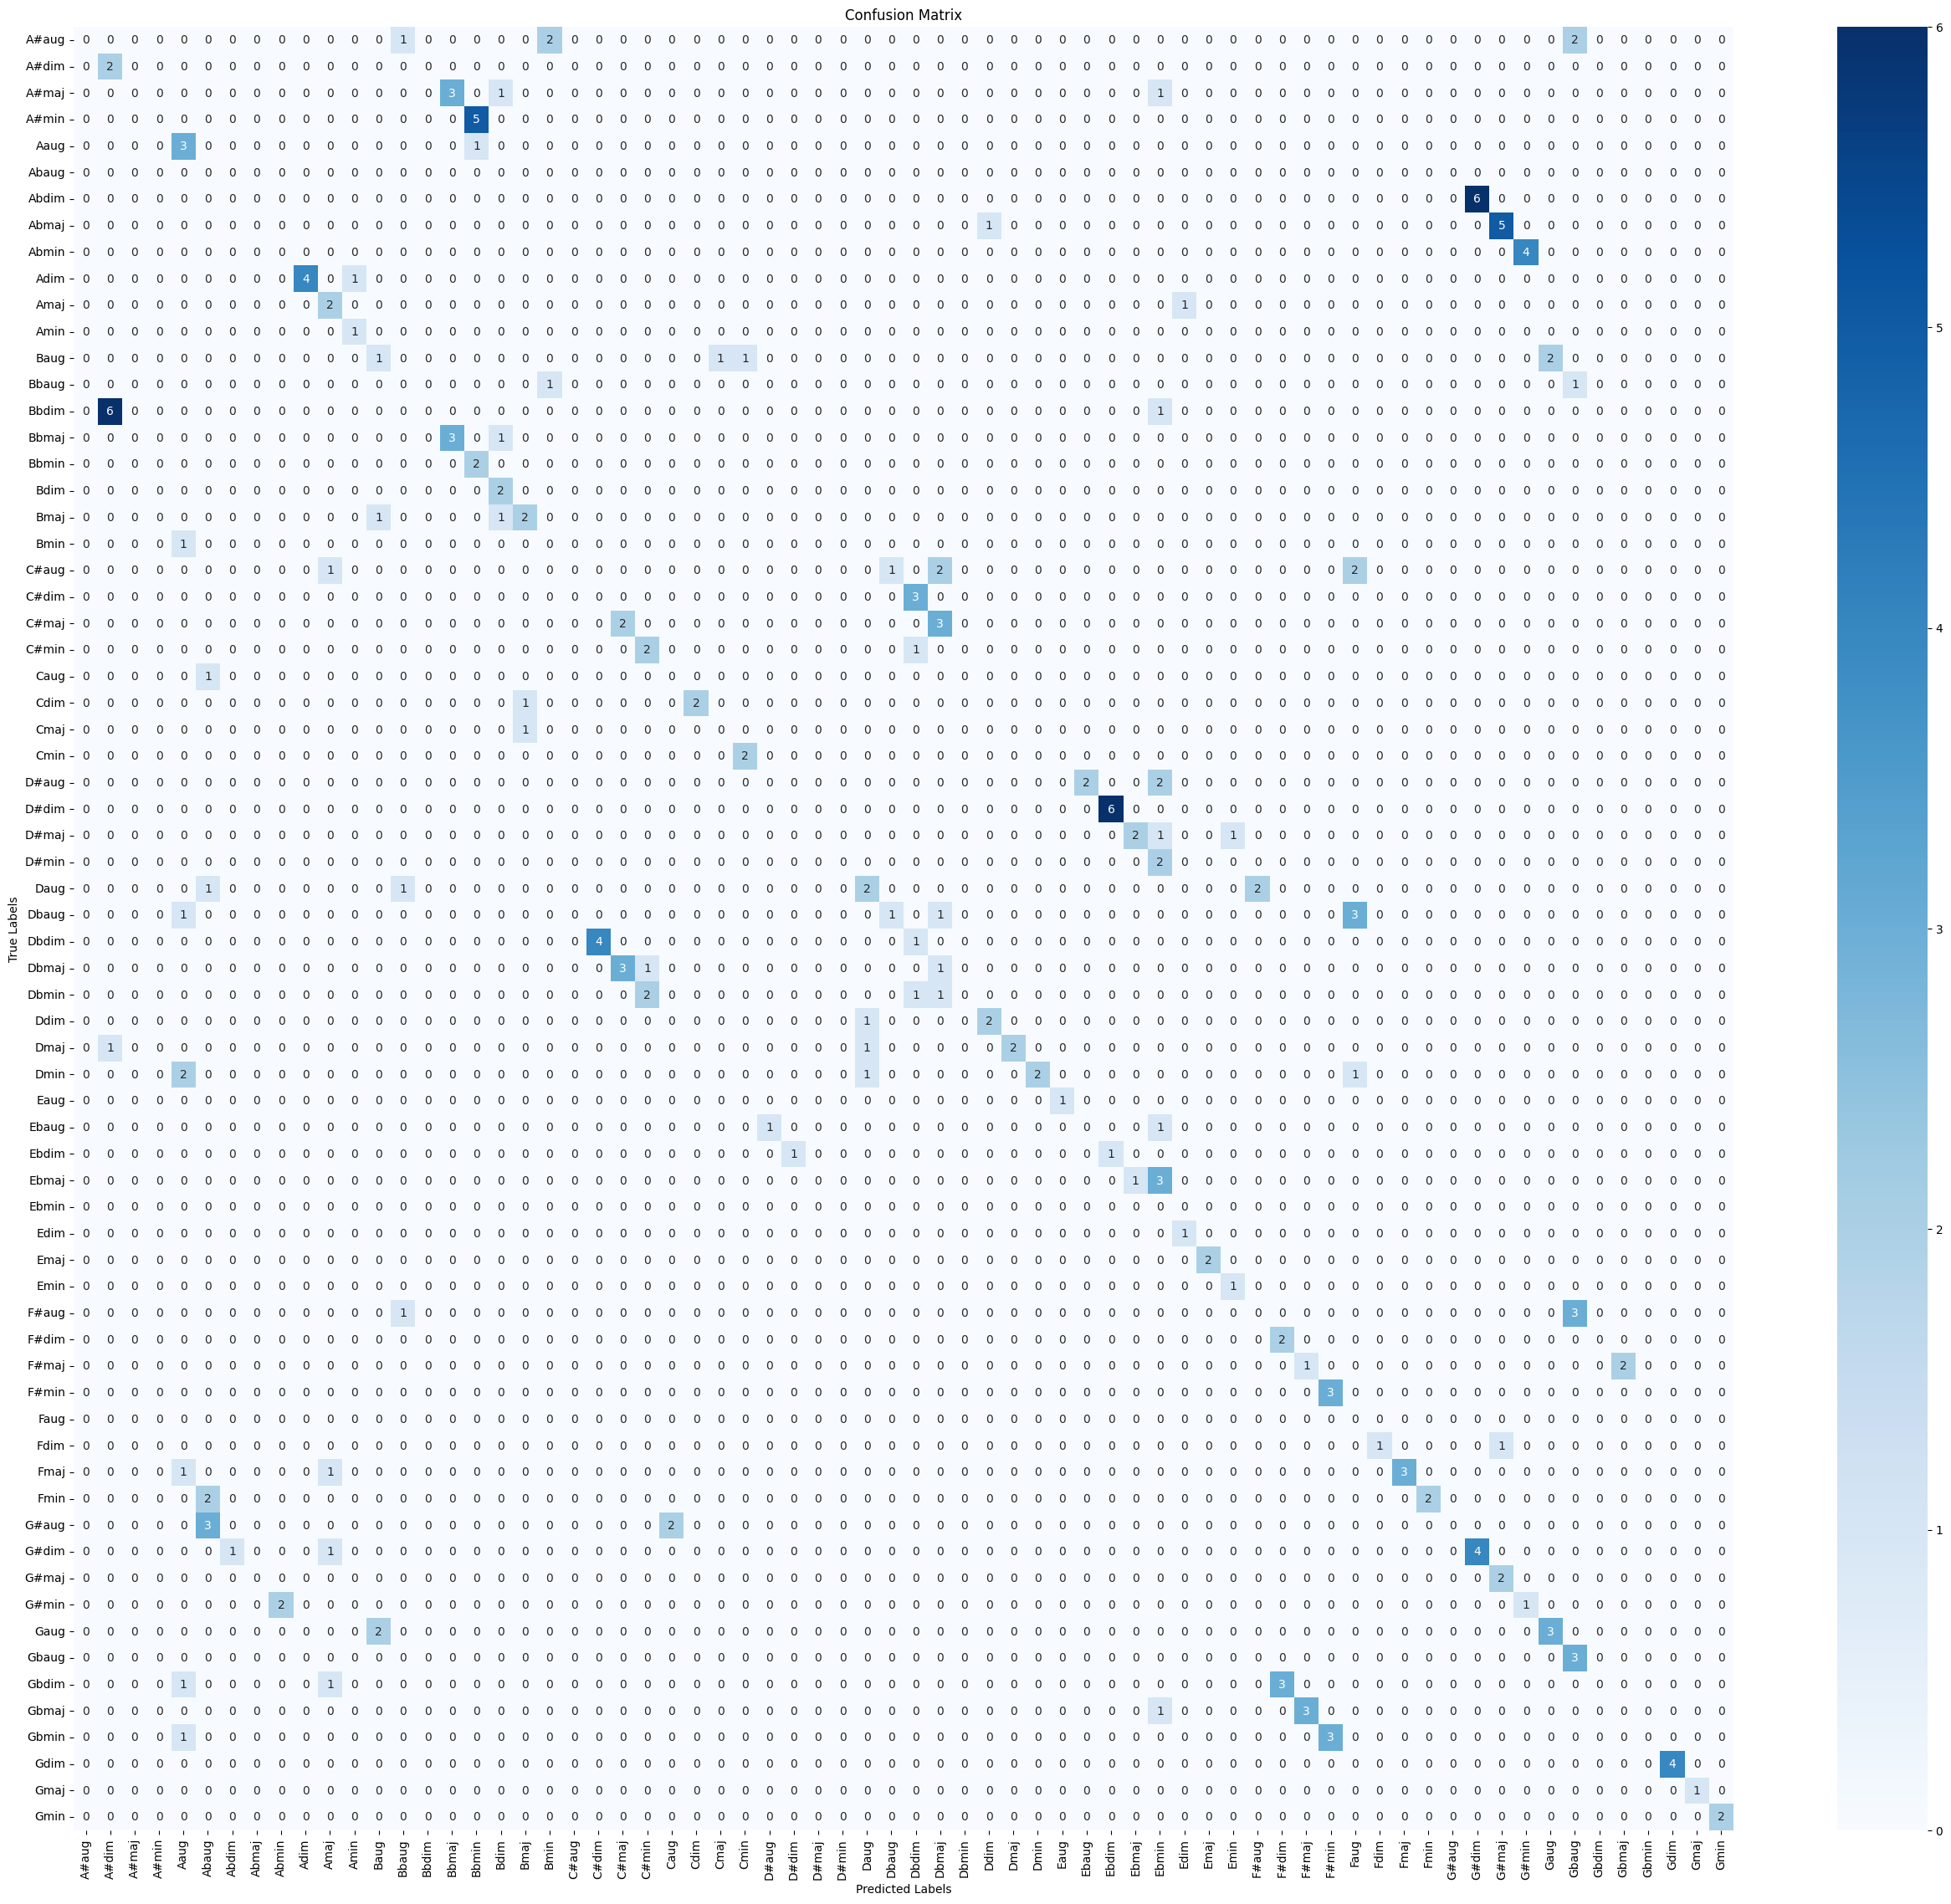

In [18]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(32, 28))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()